In [87]:
using JuMP, MathOptInterface, Gurobi;
using Plots, JSON;
const MOI = MathOptInterface;
const MOIU = MOI.Utilities;


const VI = MOI.VariableIndex

MathOptInterface.VariableIndex

# LP Knapsack Problem

$$
\begin{array}{rl}
    \max & \mathbf{c}^{\small\mathbf{\text{T}}}\mathbf{x} \\
    \text{s.t.} & \mathbf{w}^{\small\mathbf{\text{T}}}\mathbf{x} \le C\\
    ~ & \mathbf{x}_i \in \{0, 1\}
\end{array}
$$

In [115]:
# Model definition
# References:
# [1] https://jump.dev/MathOptInterface.jl/stable/tutorials/example/

model = MOIU.Model{Float64}()

n = 3;
c = [1.0, 2.0, 3.0]
w = [3.0, 5.0, 10.0]
C = 16.0;

x = MOI.add_variables(model, n);

# ---------
# Objective
# ---------
MOI.set(model, MOI.ObjectiveSense(), MOI.MAX_SENSE)

MOI.set(
   model,
   MOI.ObjectiveFunction{MOI.ScalarAffineFunction{Float64}}(),
   MOI.ScalarAffineFunction(MOI.ScalarAffineTerm.(c, x), 0.0),
);

# -----------
# Constraints
# -----------
MOI.add_constraint(
   model,
   MOI.ScalarAffineFunction(MOI.ScalarAffineTerm.(w, x), 0.0),
   MOI.LessThan(C),
);

for xᵢ in x
   MOI.add_constraint(model, xᵢ, MOI.ZeroOne())
end

In [116]:
include("../src/ToQUBO.jl")

gurobi = Gurobi.Optimizer()

MOI.set(gurobi, MOI.Silent(), true)

qubo = ToQUBO.toqubo(model, quantum=true)

print(qubo.model)

println.("$vᵢ = $xᵢ" for (vᵢ, xᵢ) in ToQUBO.solvequbo(qubo, model=gurobi));

Set parameter Username
Academic license - for non-commercial use only - expires 2022-02-02
x₁ = 0.0
x₂ = 1.0
x₃ = 1.0
s₁ = 1.0


In [117]:
function viability(qubo::ToQUBO.QUBOModel{T}, s::Vector{Int})::Bool where T
    t = [vᵢ for v in qubo.varvec for vᵢ in v.target]
    return (convert(T, qubo.Eᵢ(Dict{VI, T}(t[i] => s[i] for i=1:length(t)))) === convert(T, 0))
end

viability (generic function with 2 methods)

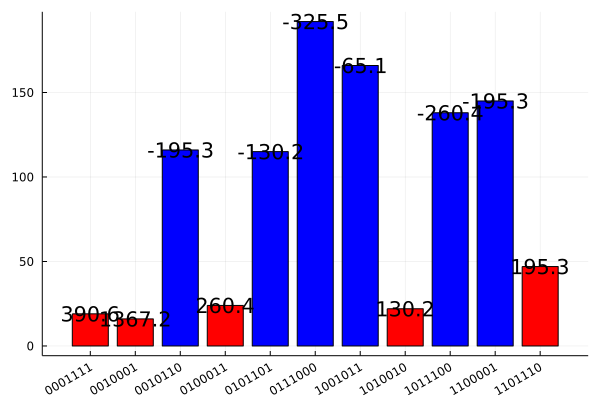

In [118]:
open("qubo.json", "w") do io
    write(io, ToQUBO.tojson(qubo))
end;

run(`python anneal qubo.json`);

open("anneal.json", "r") do io
    S = Vector{Vector{Int}}()
    N = Vector{Int}()
    E = Vector{Float64}()

    for entry in JSON.parse(read(io, String))
        push!(S, entry["states"])
        push!(N, entry["samples"])
        push!(E, entry["energy"])
    end

    i = sortperm(S)


    x = [join(s, "") for s in S[i]]
    y = N[i]
    z = ["$(round(zᵢ * 10^5, digits=1))" for zᵢ in E[i]]
    
    c = [(viability(qubo, s) ? :blue : :red) for s in S[i]]
    
    bar(x, y, xrotation=30, xticks=(0.5:1:length(x)-0.5, x), legend=false, txt=z, tickfontsize=8, color=c)
end